# Análisis de hipótesis y test A/B

In [1]:
#importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import timedelta
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest



In [2]:
#cargar y guardar datasets
hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')
orders = pd.read_csv('/datasets/orders_us.csv')
visits = pd.read_csv('/datasets/visits_us.csv')

## Preparación y limpieza de datasets

In [3]:
#hypotheses dataframe
print(hypotheses.info())
hypotheses.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None


,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1


In [4]:
#orders dataframe
print(orders.info())
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB
None


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [5]:
# verificar datos nulos y datos duplicados
print(orders.isnull().sum())
print(orders.duplicated().sum())

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64
0


In [6]:
# verificar si algunos de los visitantes podrían haber entrado tanto en el grupo A como en el grupo B.
grupo_por_usuario = orders.groupby('visitorId')['group'].nunique().reset_index()
print(grupo_por_usuario.head(5))

#si hay usarios con mas de un grupo 
count = grupo_por_usuario[grupo_por_usuario==2].count()
print(count)

#son 58 usuarios los que estan en ambos grupos
#eliminarlos del dataframe
usuarios_mix = grupo_por_usuario[grupo_por_usuario['group'] > 1]['visitorId']
orders = orders[~orders['visitorId'].isin(usuarios_mix)]
orders.info()


   visitorId  group
0    5114589      1
1    6958315      1
2    8300375      2
3   11685486      1
4   39475350      1
visitorId     0
group        58
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1016 non-null   int64  
 1   visitorId      1016 non-null   int64  
 2   date           1016 non-null   object 
 3   revenue        1016 non-null   float64
 4   group          1016 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 47.6+ KB


In [7]:
print(visits.info())
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [8]:
# verificar datos nulos y datos duplicados
print(visits.isnull().sum())
print(visits.duplicated().sum())

date      0
group     0
visits    0
dtype: int64
0


## Análisis de datos


### Priorizar hipótesis

Metodo **ICE** <br>
ICE: (Impact × Confidence) / Effort

In [9]:
hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


In [10]:
hypotheses['ICE'] = (hypotheses['Impact'] * hypotheses['Confidence']) / hypotheses['Effort']
ICE = hypotheses[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False).round(1)
ICE

,Hypothesis,ICE
8,Launch a promotion that gives users discounts ...,16.2
0,Add two new channels for attracting traffic. T...,13.3
7,Add a subscription form to all the main pages....,11.2
6,Show banners with current offers and sales on ...,8.0
2,Add product recommendation blocks to the store...,7.0
1,Launch your own delivery service. This will sh...,2.0
5,Add a customer review page. This will increase...,1.3
3,Change the category structure. This will incre...,1.1
4,Change the background color on the main page. ...,1.0


Metodo **RICE** <br>
ICE: (Reach * Impact × Confidence) / Effort

In [11]:
hypotheses['RICE'] = (hypotheses['Reach'] * hypotheses['Impact'] * hypotheses['Confidence']) / hypotheses['Effort']
RICE = hypotheses[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)
RICE

,Hypothesis,RICE
7,Add a subscription form to all the main pages....,112.0
2,Add product recommendation blocks to the store...,56.0
0,Add two new channels for attracting traffic. T...,40.0
6,Show banners with current offers and sales on ...,40.0
8,Launch a promotion that gives users discounts ...,16.2
3,Change the category structure. This will incre...,9.0
1,Launch your own delivery service. This will sh...,4.0
5,Add a customer review page. This will increase...,4.0
4,Change the background color on the main page. ...,3.0


**Conclusión**

### Análisis del test A/B

1.- Representa gráficamente el ingreso acumulado por grupo. Haz conclusiones y conjeturas.

In [12]:
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A


In [13]:
orders['date'] = pd.to_datetime(orders['date'])
cumulative_revenue = (orders.groupby(['group', 'date'])['revenue']
                    .sum()
                    .groupby(level=0)
                    .cumsum()
                    .reset_index())
display(cumulative_revenue)



,group,date,revenue
0,A,2019-08-01,2266.6
1,A,2019-08-02,3734.9
2,A,2019-08-03,5550.1
3,A,2019-08-04,6225.6
4,A,2019-08-05,7623.6
...,...,...,...
57,B,2019-08-27,71885.0
58,B,2019-08-28,72895.5
59,B,2019-08-29,74576.7
60,B,2019-08-30,77863.5


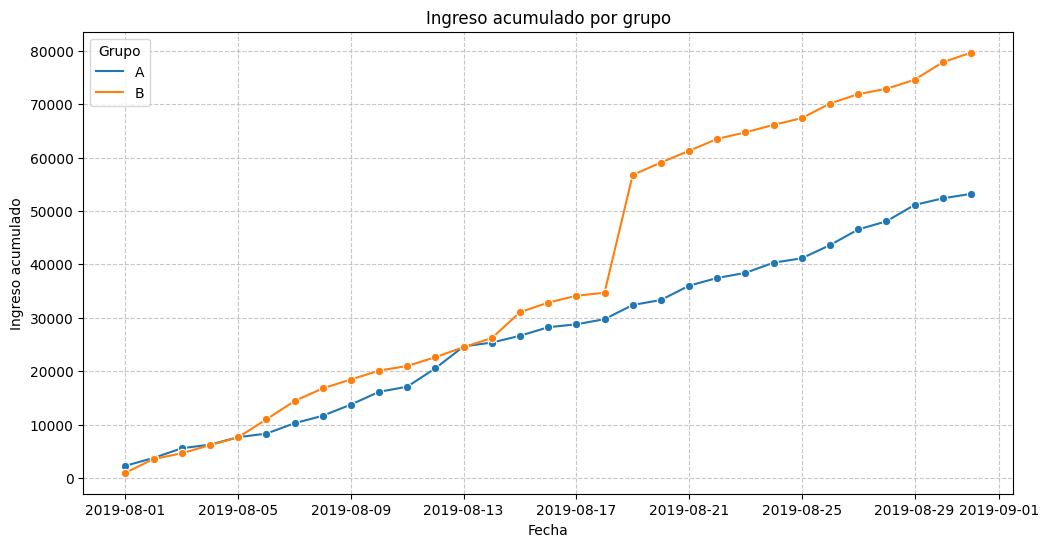

In [14]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=cumulative_revenue,
    x="date",
    y="revenue",
    hue="group",
    marker="o"  
)

plt.title("Ingreso acumulado por grupo")
plt.xlabel("Fecha")
plt.ylabel("Ingreso acumulado")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(title="Grupo")
plt.show()

**conclusiones**  los dos drupos empiezan de una manera similar pero cerca del 20 de agosto el grupo B tiene un pendeinte mas pronunciada, puede que hubo algun cambio importante como una promocion o una buena campaña la que hizo que el grupo B tome la delantera por mucho, o tal vez algunos valores atipicos que tenemos que revisar mas adelante|


2.- Representa gráficamente el tamaño de pedido promedio acumulado por grupo. Haz conclusiones y conjeturas.

In [15]:
cumulative_orders = (
    orders.groupby(['group', 'date'])
    .agg(total_revenue=('revenue', 'sum'), total_orders=('transactionId', 'count'))
    .groupby(level=0)
    .cumsum()
    .reset_index()
)


cumulative_orders['average_order_size'] = cumulative_orders['total_revenue'] / cumulative_orders['total_orders']


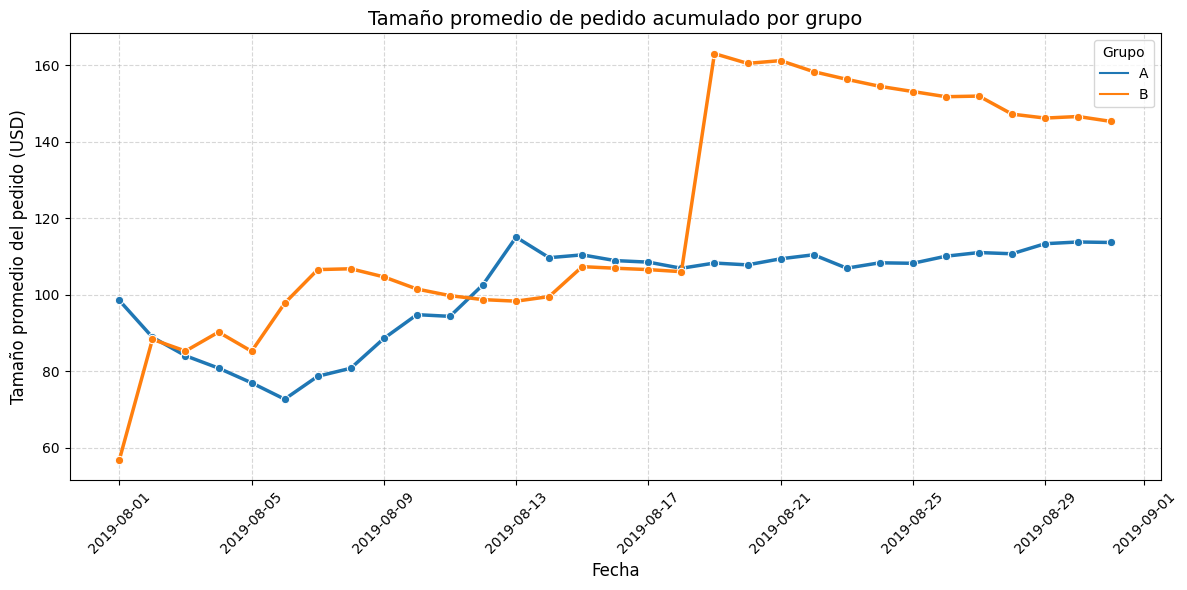

In [16]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=cumulative_orders,
    x="date",
    y="average_order_size",
    hue="group",
    marker="o",
    linewidth=2.5
)

plt.title("Tamaño promedio de pedido acumulado por grupo", fontsize=14)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Tamaño promedio del pedido (USD)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Grupo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**conclusiones** empiezan los dos grupo con bastante diferencia pero luego se empetan donde el grupo B tiene marca la delantera lo que indica que tiene un mayo promedio acumulado esos dias, por el otro lado el grupo A va subiendo pero luego se estabiliza por el contrario el grupo A tiene un repunte por el dia 20 pero luego cae poco a poco, de todas formas termina con gran ventaja sobre el grupo A, quiere decir que el repunte ayudo bastante, siendo una camapaña de merketin existosa, algun descuento o hasta algun lugar atipico

3.- Representa gráficamente la diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A.

In [17]:
group_a = cumulative_orders[cumulative_orders["group"] == "A"][["date", "average_order_size"]]
group_b = cumulative_orders[cumulative_orders["group"] == "B"][["date", "average_order_size"]]

comparison = pd.merge(
    group_a.rename(columns={"average_order_size": "avg_A"}),
    group_b.rename(columns={"average_order_size": "avg_B"}),
    on="date",
    how="outer"
)

comparison["relative_diff"] = ((comparison["avg_B"] - comparison["avg_A"]) / comparison["avg_A"]) * 100
comparison.head()

,date,avg_A,avg_B,relative_diff
0,2019-08-01,98.547826,56.894118,-42.267506
1,2019-08-02,88.926190,88.382500,-0.611395
2,2019-08-03,84.092424,85.312963,1.451425
3,2019-08-04,80.851948,90.272059,11.651062
4,2019-08-05,77.006061,85.256180,10.713597


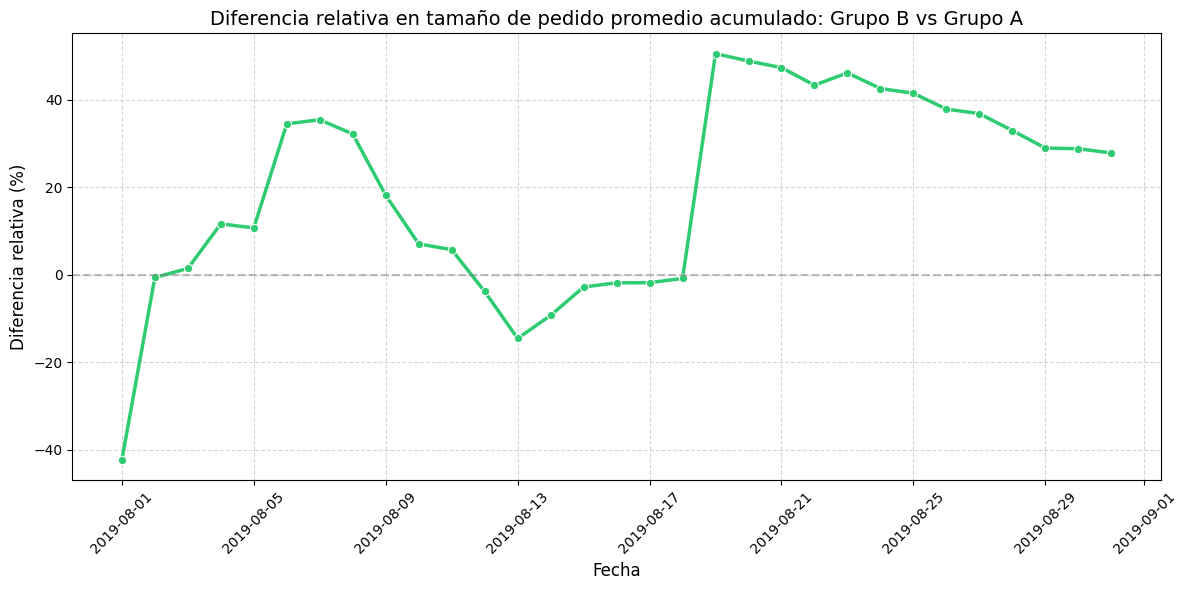

In [18]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=comparison,
    x="date",
    y="relative_diff",
    color="#2ecc71",  
    marker="o",
    linewidth=2.5
)


plt.axhline(0, color="gray", linestyle="--", alpha=0.5)

plt.title("Diferencia relativa en tamaño de pedido promedio acumulado: Grupo B vs Grupo A", fontsize=14)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Diferencia relativa (%)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

**conclusiones** analizando la grafica nos damos cuenta que la mayoria de veces el grupo B es mayor que el A sobre el pedido promedio acumulado la maxima ventaja se ha visto cerca del dia 20 como en los otros graficos donde lelga a se cerca del 50% la ventaja mas grande entre ambos grupos, B sigue afirmado que saca por mucho la delantera sobre le grupo A

4.- Calcula la tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día. Representa gráficamente las tasas de conversión diarias de los dos grupos y describe la diferencia.

In [38]:
visits['date'] = pd.to_datetime(visits['date'])

In [44]:
visits

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [50]:
# 1. Ordenes únicas por día y grupo 
ordenes_unicas_dia_grupo = (
    orders[['date','group','transactionId']]
    .sort_values(by='date',ascending=True)
    .groupby(['date','group'])
    .nunique()
    .reset_index()
    .rename(columns={'transactionId':'ordenes_diarias'})
    
)

ordenes_acumuladas = (
    ordenes_unicas_dia_grupo
    .groupby('group')[['date','group','ordenes_diarias']]
    .apply(lambda x: x.sort_values('date').assign(ordenes_acumuladas=lambda x: x['ordenes_diarias'].cumsum()))
    .reset_index(drop=True)
)

# 3. Visitas  acumulado por grupo
visitas_acumuladas = (
    visits
    .sort_values(['group', 'date'])  
    .groupby('group', group_keys=False)  
    .apply(lambda x: x.assign(visitas_acumuladas=x['visits'].cumsum()))
    [['date', 'group', 'visitas_acumuladas']]
)

#merged ambos df
merged_data = ordenes_acumuladas.merge(
    visitas_acumuladas,
    on=['date','group'],
    how='inner'
)

merged_data['conversion_rate'] = merged_data['ordenes_acumuladas'] / merged_data['visitas_acumuladas']

merged_data


,date,group,ordenes_diarias,ordenes_acumuladas,visitas_acumuladas,conversion_rate
0,2019-08-01,A,23,23,719,0.031989
1,2019-08-02,A,19,42,1338,0.031390
2,2019-08-03,A,24,66,1845,0.035772
3,2019-08-04,A,11,77,2562,0.030055
4,2019-08-05,A,22,99,3318,0.029837
...,...,...,...,...,...,...
57,2019-08-27,B,11,473,16523,0.028627
58,2019-08-28,B,22,495,17177,0.028818
59,2019-08-29,B,15,510,17708,0.028801
60,2019-08-30,B,21,531,18198,0.029179


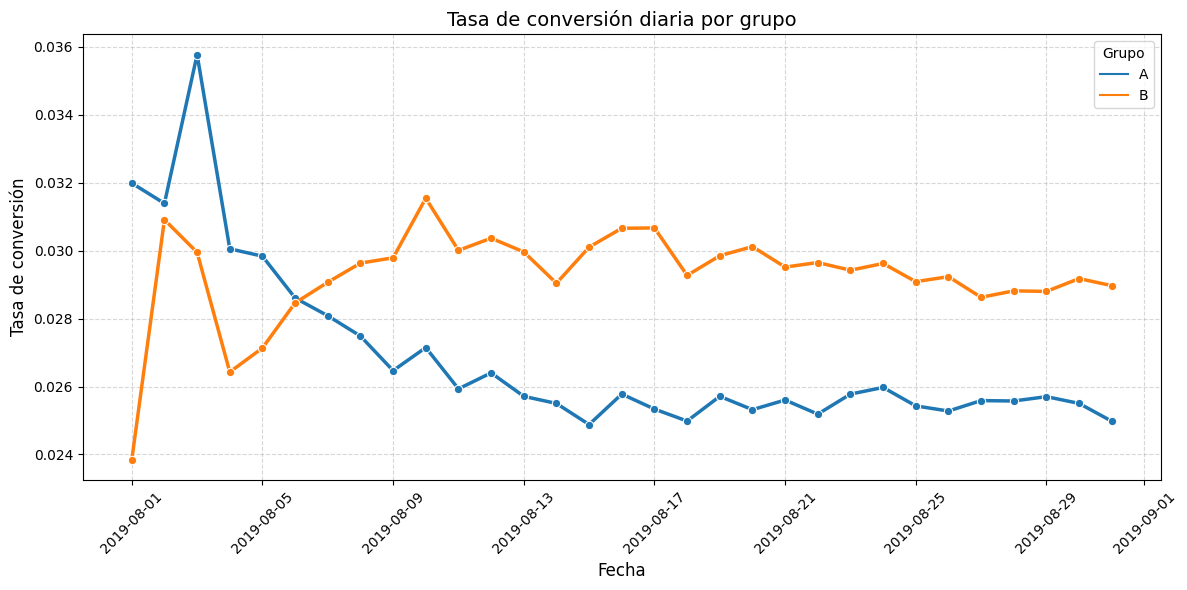

In [48]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=merged_data,
    x="date",
    y="conversion_rate",
    hue="group",
    marker="o",
    linewidth=2.5
)

plt.title("Tasa de conversión diaria por grupo", fontsize=14)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Tasa de conversión", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Grupo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Conclusiones** al hacer los calculos con la data acumulada se puede observar mejor que el grupo B tiene una mejor tasa de conversión que el grupo A aunque al principio gana el grupo A se ve que despues de unos dias el grupo B sobrepasa y queda por la delantera

5.- Traza un gráfico de dispersión del número de pedidos por usuario.

In [ ]:
# Agrupar por usuario y contar pedidos
orders_per_user = (
    orders.groupby("visitorId")["transactionId"]
    .count()
    .reset_index()
    .rename(columns={"transactionId": "total_orders"})
)

plt.figure(figsize=(12, 6))

# Crear el scatter plot
plt.scatter(
    x=range(len(orders_per_user)),  
    y=orders_per_user["total_orders"],
    alpha=0.5,  
    color="#3498db"
)

# Personalizar
plt.title("Distribución de pedidos por usuario", fontsize=14)
plt.xlabel("Usuarios")
plt.ylabel("Número de pedidos por usuario")
plt.grid(True, linestyle="--", alpha=0.5)

**conclusiones** la mayoría de usuarios tienen solo un pedido, casi muy pocos 2 que son los usuarios recurrentes y solo 7 tiene 3 pedidos, podria decir que son los mas fieles, algo interesante es que no tenemos valores atipicos lo cual es un buen indicador que no hubo algun error, o pedidos fraude. 

6.- Calcula los percentiles 95 y 99 del número de pedidos por usuario.

In [ ]:
print('Percentiles 90/95/99:', np.percentile(orders_per_user["total_orders"], [90, 95, 99]))

**conclusiones** como vemos en la grafica de arriba un poco de menos del 1% realiza mayor o igual que 2 pedidos 

7.- Traza un gráfico de dispersión de los precios de los pedidos.

In [ ]:
# Agrupar por usuario y contar pedidos
plt.figure(figsize=(14, 7))

# Gráfico de dispersión básico
plt.scatter(
    x= range(len(orders["revenue"])),
    y=orders["revenue"],
    alpha=0.6,        # Transparencia para ver densidad
    color="#2980b9",  # Color azul
    label="Precio por pedido"
)


plt.title("Distribución de precios de los pedidos", fontsize=16)
plt.xlabel("Indice", fontsize=12)
plt.ylabel("Precio del pedido (USD)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.show()

**conclusiones** la mayoria de pedidos no pasa de 1000 dolares, lo cual esta bien pero podemos ver que hay en especifico dos pedidos atipicos un arriba de 2500 y uno ya en 20000 lo cual es algo extremadamente atipico y algo que no se habia visto, hace falta ver los perecentiles para sabes como de verdad se distribuyen los pedidos

8.- Calcula los percentiles 95 y 99 de los precios de los pedidos. Define el punto en el cual un punto de datos se convierte en una anomalía.


In [ ]:
print('Percentiles 90/95/99:', np.percentile(orders["revenue"], [90, 95, 99]))


**conclusiones** se confirma que el 95% de los pedidos no pasan de 415 dolares el pedido, el punto donde se convierte en una anomalia serian pedidos arriba de 830 dolares lo que menos del 1% de los datos cumplen 

9.- Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto.

In [ ]:
# total de visitas por grupo
visits_total = visits.groupby('group')['visits'].sum()
# total de conversiones por grupo 
conversions_total = orders.groupby('group')['transactionId'].nunique()

# Unimos en un df
summary = pd.DataFrame({
    'visits': visits_total,
    'conversions': conversions_total
})

# Tasa de conversión
summary['conversion_rate'] = summary['conversions'] / summary['visits']
print(summary)

In [ ]:
conversions = summary['conversions'].values
visits = summary['visits'].values
z_stat, p_val = proportions_ztest(conversions, visits)

print(f"Z-stat: {z_stat:.4f}")
print(f"P-value: {p_val:.4f}")

alpha = 0.05 

if p_val > alpha:
    print(f"No hay diferencia significativa (p = {p_val:.4f})")
    print("No se puede concluir que un grupo convierta mejor que el otro.")
else:
    print(f"Diferencia significativa (p = {p_val:.4f})")
    print("Hay evidencia estadística de que un grupo tiene mejor conversión.")

**conclusiones** como el valor z es negativo esto indica que el grupo B tiene mejor tasa de conversion y como el p-value es menor que alpha esto quiere decir que hay un grupo que si tiene una mejor conversion clara, en este caso el grupo B

10.- Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto.

In [ ]:
# filtra revenue por grupo
group_A = orders[orders['group'] == 'A']['revenue']
group_B = orders[orders['group'] == 'B']['revenue']

#aplicar prueba robusta mannwhitneyu
u_stat, pval_rev = stats.mannwhitneyu(group_A, group_B, alternative='two-sided')
print(f"U-stat: {u_stat}")
print(f"P-value: {pval_rev:.4f}")

alpha = 0.05

if pval_rev > alpha:
    print("No hay diferencia significativa en el tamaño promedio de pedido.")
else:
    print("Sí hay diferencia significativa en el tamaño promedio de pedido.")

**conclusiones** al ver que no hay una diferenfcia significatica del promedio de pedido, esto sugiere que ambos grupos gastan aproximadamente lo mismo cuando compran, pero si tomamos los datos que el grupo B tiene mejor conversion, este sigue con la delantera 

11.- Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados. 

In [ ]:
# Calculamos el percentil 99
revenue_threshold = orders['revenue'].quantile(.98).round(2)
print(revenue_threshold)
#filtramos df 
filtered_orders = orders[orders['revenue'] <= revenue_threshold]
#se agrupa para contar las conversiones filtradas
filtered_conversions = filtered_orders.groupby('group')['transactionId'].nunique()
#visits sigue igual, unimos df
filtered_summary = pd.DataFrame({
    'visits': visits_total,
    'conversions': filtered_conversions
})
#calcula la tasa de conversion
filtered_summary['conversion_rate'] = filtered_summary['conversions'] / filtered_summary['visits']
print(filtered_summary)

In [ ]:
#se aplica mismo test pero ahora con el df filtrado
conversions = filtered_summary['conversions'].values
visits = filtered_summary['visits'].values
z_stat, p_val = proportions_ztest(conversions, visits)

print(f"Z-stat: {z_stat:.4f}")
print(f"P-value: {p_val:.4f}")

alpha = 0.05 

if p_val > alpha:
    print(f"No hay diferencia significativa (p = {p_val:.4f})")
    print("No se puede concluir que un grupo convierta mejor que el otro.")
else:
    print(f"Diferencia significativa (p = {p_val:.4f})")
    print("Hay evidencia estadística de que un grupo tiene mejor conversión.")

**conclusion** al filtrar el df nos damos cuenta que no hubo tanta diferencia, ya que los valores atipicos era muy pocos, al ver que el p-value es menor que alpha ya sin valores atipicos, se pude concluir de una manera mas segura que B tiene mejor conversion que A 

12.- Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados.

In [ ]:
#ya contamos con el df filtrado filtered_orders

# filtra revenue por grupo
group_A = filtered_orders[filtered_orders['group'] == 'A']['revenue']
group_B = filtered_orders[filtered_orders['group'] == 'B']['revenue']

#aplicar prueba robusta mannwhitneyu
u_stat, p_value = stats.mannwhitneyu(group_A, group_B, alternative='two-sided')
print(f"U-stat: {u_stat}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
if p_value > alpha:
    print("No hay diferencia significativa en el tamaño promedio de pedido.")
else:
    print("Sí hay diferencia significativa en el tamaño promedio de pedido.")

**conclusion** una vez mas con los datos filtados no hay evidencia estadística suficiente para afirmar que hay una diferencia en el tamaño promedio de pedido entre los grupos A y B una vez pero al ver que B tiene mejor conversion sigue por adelante

## Conclusión


Por un lado en la prueba de conversión se vio que el grupo B convierte **significativamente** mejor y por otro lado se vio que el tamaño promedio de pedido no hay una diferencia significativa. Esto indica que B convierte mejor sin comprometer el valor por transacción, por lo que se recomienda detener la prueba y adoptar el grupo B como la variante ganadora.